In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device} device")

Using cuda device


In [9]:
path = 'https://bit.ly/ds_boston_csv'
data = pd.read_csv(path)

target = 'medv'
features = ['lstat', 'ptratio', 'crim']
x = data.loc[:, features]
y = data.loc[:, target]

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=.2, random_state = 20)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [10]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size=32):

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1,1)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, x_val_tensor, y_val_tensor

In [11]:
y_val = y_val.values
y_train = y_train.values

In [12]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

for x,y in train_loader:
    print(f'Shape of x [rows, columns]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


In [13]:
n_feature = x.shape[1]
model1 = nn.Sequential(nn.Linear(n_feature, 1)).to(device)
loss_fn = nn.MSELoss()
optimizer = Adam(model1.parameters(), lr=0.01)
print(model1)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)


In [14]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss =0
    model.train()
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

In [15]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        x,y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        val_loss = loss_fn(pred, y).item()
    return val_loss, pred


In [19]:
epochs = 500
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train_loss: {tr_loss:.4f}, val loss: {val_loss:.4f}')


Epoch 1, train_loss: 250.6839, val loss: 189.3142
Epoch 2, train_loss: 250.8441, val loss: 186.4934
Epoch 3, train_loss: 246.8128, val loss: 183.6538
Epoch 4, train_loss: 244.9020, val loss: 180.9316
Epoch 5, train_loss: 239.9669, val loss: 178.2743
Epoch 6, train_loss: 239.4542, val loss: 175.7498
Epoch 7, train_loss: 239.8288, val loss: 173.2857
Epoch 8, train_loss: 234.4687, val loss: 170.8575
Epoch 9, train_loss: 231.2242, val loss: 168.5056
Epoch 10, train_loss: 226.3950, val loss: 166.2189
Epoch 11, train_loss: 225.3915, val loss: 164.0536
Epoch 12, train_loss: 222.8944, val loss: 161.9126
Epoch 13, train_loss: 222.7594, val loss: 159.8165
Epoch 14, train_loss: 222.2022, val loss: 157.8477
Epoch 15, train_loss: 219.0517, val loss: 155.8920
Epoch 16, train_loss: 215.2868, val loss: 153.9848
Epoch 17, train_loss: 210.4910, val loss: 152.1242
Epoch 18, train_loss: 209.3679, val loss: 150.3568
Epoch 19, train_loss: 207.6361, val loss: 148.6862
Epoch 20, train_loss: 209.0016, val loss

In [17]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs= list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker='.')
    plt.plot(epochs, val_loss_list, label='val_err', marker='.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

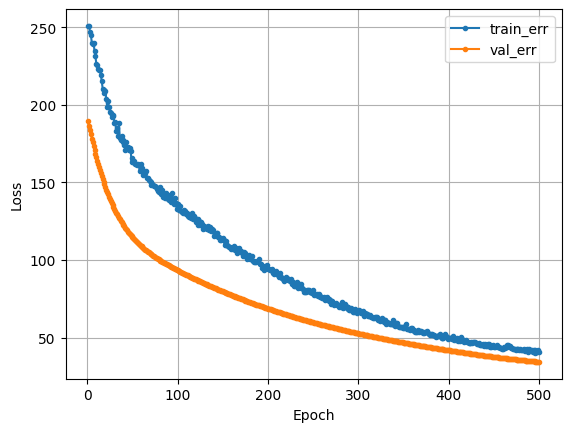

In [20]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [24]:
_, pred = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
mae = mean_absolute_error(y_val_ts.cpu().numpy(), pred.cpu().numpy())
mape = mean_absolute_percentage_error(y_val_ts.cpu().numpy(), pred.cpu().numpy())
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 4.364735126495361
MAPE: 0.20824724435806274
